<a href="https://colab.research.google.com/github/ananya15082002/Avataar_Assignment/blob/main/Avataar_H1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><b>Assignment: Placing an Object’s Image in a Text-Conditioned Scene</b></h1>
<small><i>By Ananya</i></small>

---

## **Objective**

The goal of this project is to place an object image into a realistic, text-conditioned scene using generative AI techniques. We will use pre-trained models, specifically Stable Diffusion, to composite an object onto a scene that aligns with a given text prompt. The result should be coherent and as natural-looking as possible.



***Key Goals:***

**Alignment with text prompt:**  The background should align with the user’s text prompt (e.g., "A modern kitchen").

**Keep the product unaltered:**  The input product image should not be distorted or altered, just resized and placed in the background.

**Natural placement:**  The product should be placed naturally in the generated scene (e.g., on a surface like a countertop).

**Steps Overview:**
**Remove background from the product image:** We need to preprocess the input image to remove its background and make it easier to blend into the generated background.

**Generate background:** Using a text prompt, generate an appropriate background that fits the description.

**Place the product intelligently:** Based on the background, identify natural surfaces like countertops, and place the product in a realistic location.
Iterate the process: The user can keep inputting images and text prompts until they choose to exit.

***Let's divide the code into chunks with step-by-step instructions:***


---

## **1. Setup and Dependencies**

We begin by installing the necessary dependencies. These include `diffusers` and `transformers` for using the Stable Diffusion model, and `opencv-python` for image processing.

**Why used?**

**Transformers and Diffusers:** For generating the background image based on the text prompt.

**Rembg:** For removing the background of the input product image.

**OpenCV:** For processing and detecting surfaces in the background image.
### **Installing Dependencies**


In [7]:
# Install necessary packages
!pip install transformers diffusers rembg moviepy matplotlib opencv-python


***2. Preprocessing the Object Image***                                                       
In this step, we will preprocess the object image to remove the background, which will allow us to composite it into the generated scene more naturally.

**Rembg** is used to ensure the product can be placed on any background without the original background interfering.



In [9]:
import torch
from PIL import Image
from rembg import remove

# Function to remove background from the product image
def remove_background(input_image_path, output_image_path):
    with open(input_image_path, "rb") as input_file:
        input_image = input_file.read()
    output_image = remove(input_image)

    # Save the image as PNG to preserve transparency
    with open(output_image_path, "wb") as output_file:
        output_file.write(output_image)

    # Ensure the output image has an alpha channel (transparency)
    product = Image.open(output_image_path)
    if product.mode != 'RGBA':
        product = product.convert('RGBA')
    product.save(output_image_path)

# Test with a sample input product image
remove_background("/content/example1.jpg", "/content/extracted_product.png")


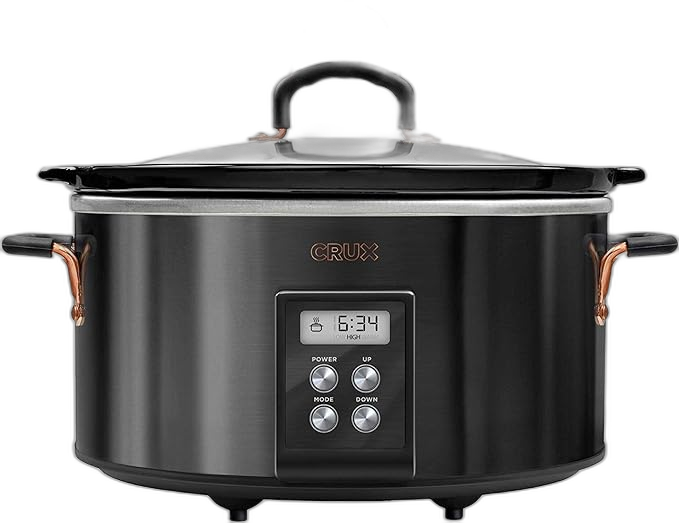

**3. Identify the product using a pre-trained model**

**Why used?**

transformers pipeline allows us to use a pre-trained model to classify images. In this case, we are using a vision transformer model (google/vit-base-patch16-224), which is good for image classification.

In [10]:
from transformers import pipeline

# Function to identify the product
def identify_product(input_image_path):
    classifier = pipeline("image-classification", model="google/vit-base-patch16-224")
    result = classifier(input_image_path)
    product_label = result[0]['label']
    return product_label

# Test product identification
product_name = identify_product("/content/extracted_product.png")
print(f"Identified product: {product_name}")


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Identified product: Crock Pot


**4. Generate background based on the user’s text prompt **




In [37]:
from diffusers import StableDiffusionPipeline
import torch

# Function to generate background based only on a text prompt
def generate_background(text_prompt, output_background_path):
    model = StableDiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    ).to("cuda" if torch.cuda.is_available() else "cpu")

    # Use only the user-provided text prompt for generating the background
    generated_image = model(prompt=text_prompt).images[0]
    generated_image.save(output_background_path)

# Example background generation using only the text prompt
generate_background("A bright kitchen with an open counter and utensils hanging on the wall, providing space for product placement", "/content/generated_background.png")


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  warnings.warn(



  0%|          | 0/50 [00:00<?, ?it/s]

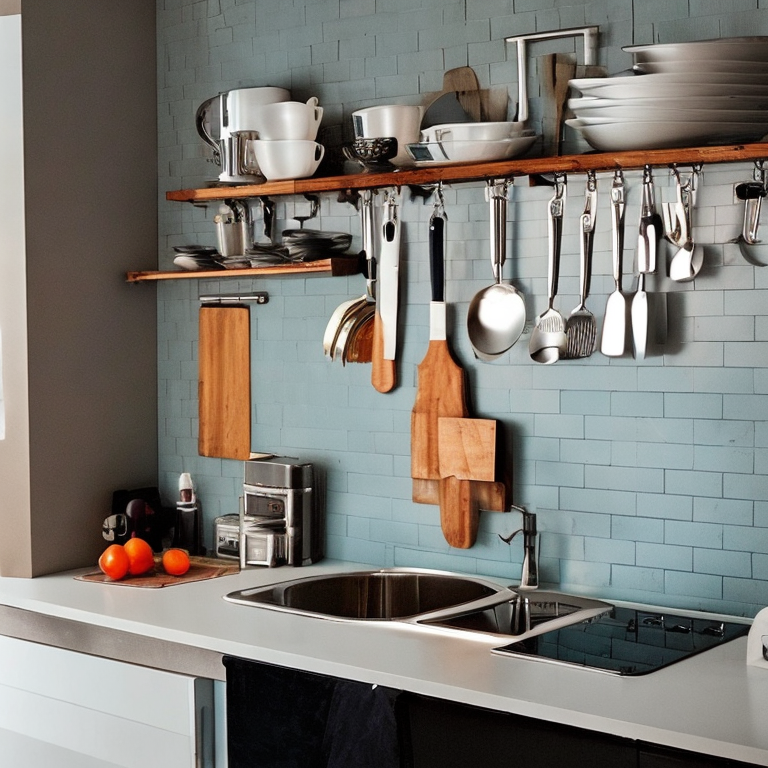

**5: Surface Detection Using Edge Detection and Contour Analysis**

**Why Used?**

**Canny Edge Detection:**  Detects the edges in the image to highlight boundaries of objects and surfaces.

**Contour Detection:** Helps to detect the surfaces (like tables or countertops) in the background.

**Bounding Box Calculation:** Provides an area where the product can be intelligently placed.


In [38]:
import cv2
from PIL import Image
import numpy as np

# Function to detect surfaces in the generated background
def detect_surfaces(background_path):
    # Load background image using OpenCV
    background_image = cv2.imread(background_path)

    # Convert the image to grayscale
    gray = cv2.cvtColor(background_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detection to detect edges in the image
    edges = cv2.Canny(blurred, 50, 150)

    # Detect contours in the image based on the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours for visualization (optional, useful for debugging)
    cv2.drawContours(background_image, contours, -1, (0, 255, 0), 2)

    # Save a debug image showing the detected contours (optional)
    cv2.imwrite("/content/debug_contours.png", background_image)

    # Find the bounding box of the largest contour (likely a surface like a table or counter)
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return (x, y, w, h)  # Return the bounding box coordinates of the largest surface

    return None  # No surface detected

# Example usage to detect surfaces in the generated background
surface_box = detect_surfaces("/content/generated_background.png")
print(f"Detected surface box: {surface_box}")


Detected surface box: (524, 455, 244, 98)


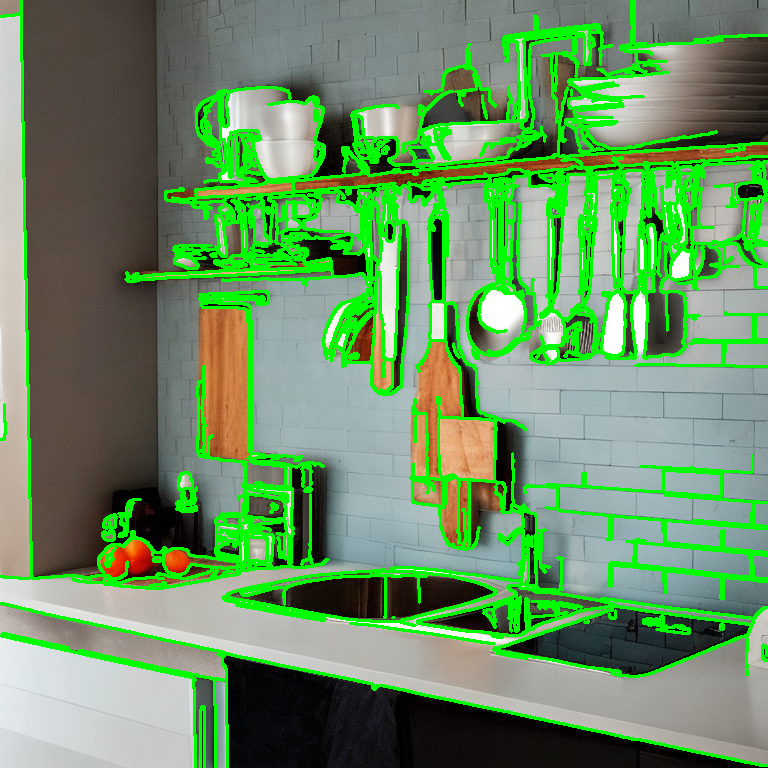

**6. with YOLO Integration:**

**Why Used?**

**YOLO Object Detection:** To identify existing objects in the generated image and their locations.

**Bounding Box Filtering:** To place the input product in areas not occupied by existing objects.



**Composite the Product onto the Detected Surface**

Once we have detected the surface, we will use the bounding box to place the product image intelligently.

**Why Used?**

**Surface Detection:** Ensures that the product is placed on a logical surface like a table or counter.

**Resizing and Placement:** The product is resized based on the surface dimensions, ensuring it fits naturally.

**Intelligent Placement:** The product is positioned intelligently based on detected surfaces, giving it a natural look.

In [39]:
import torch
import cv2
from PIL import Image
import numpy as np

# Step 5: Surface Detection Using Edge Detection (For Debugging)
def detect_surfaces(background_path, debug_output_path="/content/debug_counter.png"):
    # Load the background image
    background_image = cv2.imread(background_path)

    # Convert to grayscale for edge detection
    gray = cv2.cvtColor(background_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Use Canny edge detection to detect edges
    edges = cv2.Canny(blurred, 50, 150)

    # Detect contours from the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw contours on the original image (for debugging)
    cv2.drawContours(background_image, contours, -1, (0, 255, 0), 2)
    cv2.imwrite(debug_output_path, background_image)

    # Find the bounding box of the largest contour (likely a surface like a table or counter)
    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return (x, y, w, h)  # Return the bounding box coordinates of the largest surface

    return None  # No surface detected

# Step 6: Use YOLOv5 for Object Detection to Prevent Overlap
def detect_objects_with_yolov5(background_path):
    # Load pre-trained YOLOv5 model
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', trust_repo=True)

    # Run object detection on the background image
    results = model(background_path)

    # Extract bounding boxes and labels from the results
    objects = results.pandas().xyxy[0]
    return objects

# Step 7: Combine Edge Detection and YOLO for Intelligent Placement
def place_product_intelligently(background_path, product_path, output_composite_path):
    background = Image.open(background_path).convert("RGB")
    product = Image.open(product_path).convert("RGBA")

    # Detect surfaces using edge detection
    surface_box = detect_surfaces(background_path)

    # Detect objects using YOLOv5 to avoid placing on top of other objects
    detected_objects = detect_objects_with_yolov5(background_path)

    # Initialize default product placement in case surface is not found
    product_position = (int(background.width * 0.5), int(background.height * 0.7))

    # Check if a surface was detected
    if surface_box:
        x, y, w, h = surface_box
        product_width = int(w * 0.9)  # Scale product to 90% of surface width
        aspect_ratio = product.width / product.height
        product_height = int(product_width / aspect_ratio)
        product = product.resize((product_width, product_height), Image.LANCZOS)

        # Check if the surface is free from other objects using YOLO detections
        for _, obj in detected_objects.iterrows():
            obj_xmin, obj_ymin, obj_xmax, obj_ymax = int(obj['xmin']), int(obj['ymin']), int(obj['xmax']), int(obj['ymax'])

            # Check if object is within surface bounds
            if not (x < obj_xmin < x + w and y < obj_ymin < y + h):
                # If no overlap with detected objects, place the product on the surface
                product_position = (x + 10, y + 10)  # Place product on surface avoiding edges
                break
        else:
            # If all objects overlap with the surface, place product in a default spot
            product_position = (int(background.width * 0.5), int(background.height * 0.7))

    # Composite product onto the background
    background.paste(product, product_position, mask=product.split()[3])

    # Save the final composite image
    background.save(output_composite_path)
    print(f"Composite image saved as {output_composite_path}")

# Run the function to place the product
place_product_intelligently("/content/generated_background.png", "/content/extracted_product.png", "/content/final_composite_intelligent.png")


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-4 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
  with amp.autocast(autocast):



Composite image saved as /content/final_composite_intelligent.png


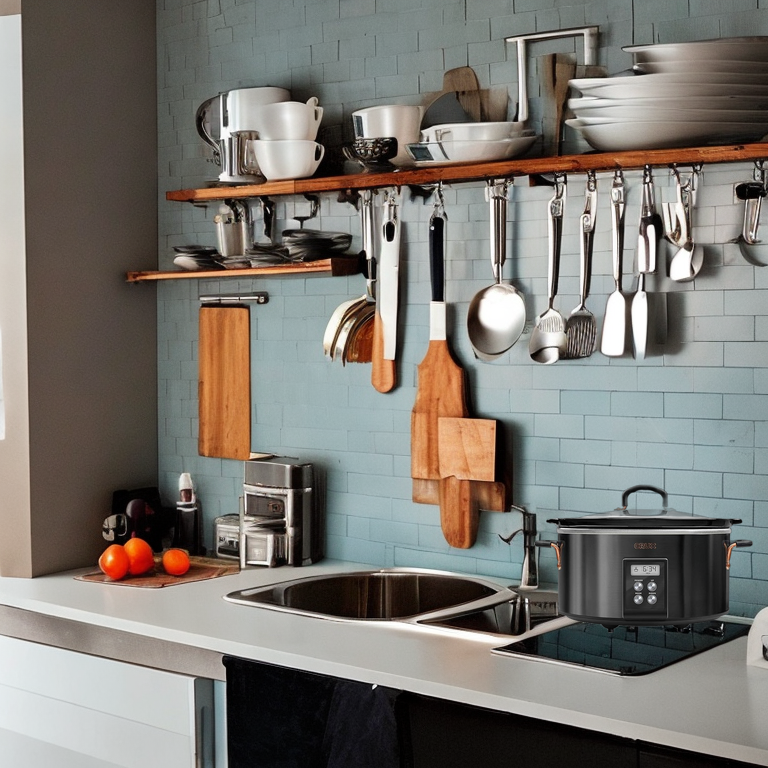

In [45]:
import numpy as np
from PIL import Image
import moviepy.editor as mpy
import cv2

# Function to create a commercial-like video with product moving in a straight path and background zoom effect
def generate_commercial_video_with_moving_product(background_path, product_path, output_video_path, num_frames=60):
    # Load the background and product images
    background = Image.open(background_path).convert("RGB")
    product = Image.open(product_path).convert("RGBA")

    # Convert images to numpy arrays
    background_np = np.array(background)
    original_bg_size = background_np.shape[:2]

    # Define product size and movement range
    product_size = (int(original_bg_size[1] * 0.2), int(original_bg_size[0] * 0.2))  # Scale product size relative to background
    product = product.resize(product_size, Image.LANCZOS)
    product_np = np.array(product)

    # Set initial position and movement increment for the product
    product_x_min = int(original_bg_size[1] * 0.1)  # Start from 10% of the width
    product_x_max = int(original_bg_size[1] * 0.8)  # End at 80% of the width
    product_y = int(original_bg_size[0] * 0.7)      # Fixed vertical position

    # Linear movement step per frame
    move_step = (product_x_max - product_x_min) // num_frames

    frames = []

    for i in range(num_frames):
        # Zoom effect on background
        zoom_factor = 1 + 0.03 * (i / num_frames)  # Gradual zoom in

        # Resize background for zoom effect
        new_bg_size = (int(original_bg_size[1] * zoom_factor), int(original_bg_size[0] * zoom_factor))
        resized_bg = Image.fromarray(background_np).resize(new_bg_size, Image.LANCZOS)

        # Crop to original size
        left = (resized_bg.width - original_bg_size[1]) // 2
        top = (resized_bg.height - original_bg_size[0]) // 2
        cropped_bg = resized_bg.crop((left, top, left + original_bg_size[1], top + original_bg_size[0]))

        # Compute new horizontal position for the product (move straight horizontally)
        product_x = product_x_min + i * move_step

        # Convert cropped background back to numpy for compositing
        cropped_bg_np = np.array(cropped_bg)

        # Composite product onto the background at the new position
        bg_pil = Image.fromarray(cropped_bg_np).convert("RGB")
        bg_pil.paste(product, (product_x, product_y), product)  # Use product's alpha mask for transparency

        # Add the frame to the list of frames
        frames.append(np.array(bg_pil))

    # Create a video clip from the frames
    clip = mpy.ImageSequenceClip([frame for frame in frames], fps=15)  # 15 FPS

    # Write the video file
    clip.write_videofile(output_video_path, codec="libx264", fps=15)
    print(f"Commercial-like video saved at {output_video_path}")

# Call the function to generate the video with zoom and moving product in a straight path
generate_commercial_video_with_moving_product("/content/generated_background.png", "/content/extracted_product.png", "/content/commercial_video.mp4")


Moviepy - Building video /content/commercial_video.mp4.
Moviepy - Writing video /content/commercial_video.mp4



Moviepy - Done !
Moviepy - video ready /content/commercial_video.mp4
Commercial-like video saved at /content/commercial_video.mp4


In [57]:
from IPython.display import display, Video

# Display the video
video_path = "/content/commercial_video.mp4" # Path to your generated video

display(Video(video_path, embed=True, width=600, height=400))


Full Code with main function for user input

In [ ]:
import torch
from PIL import Image
from rembg import remove
from transformers import pipeline
from diffusers import StableDiffusionPipeline
import cv2
import numpy as np
from IPython.display import display, Image as IPImage

# Function to remove background from the product image
def remove_background(input_image_path, output_image_path):
    with open(input_image_path, "rb") as input_file:
        input_image = input_file.read()
    output_image = remove(input_image)

    # Save the image as PNG to preserve transparency
    with open(output_image_path, "wb") as output_file:
        output_file.write(output_image)

    # Ensure the output image has an alpha channel (transparency)
    product = Image.open(output_image_path)
    if product.mode != 'RGBA':
        product = product.convert('RGBA')
    product.save(output_image_path)
    return product

# Function to identify the product using image classification
def identify_product(input_image_path):
    classifier = pipeline("image-classification", model="google/vit-base-patch16-224")
    result = classifier(input_image_path)
    product_label = result[0]['label']
    print(f"Identified product: {product_label}")
    return product_label

# Function to generate background based on the user’s text prompt
def generate_background(text_prompt, output_background_path):
    model = StableDiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2",
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
    ).to("cuda" if torch.cuda.is_available() else "cpu")

    generated_image = model(prompt=text_prompt).images[0]
    generated_image.save(output_background_path)
    return generated_image

# Function to detect surfaces in the generated background
def detect_surfaces(background_path):
    background_image = cv2.imread(background_path)
    gray = cv2.cvtColor(background_image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(background_image, contours, -1, (0, 255, 0), 2)
    cv2.imwrite("/content/debug_contours.png", background_image)

    if len(contours) > 0:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        return (x, y, w, h)
    return None

# YOLOv5 Object Detection
def detect_objects_with_yolov5(background_path):
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', trust_repo=True)
    results = model(background_path)
    objects = results.pandas().xyxy[0]
    return objects

# Function to place the product intelligently in the generated background
def place_product_intelligently(background_path, product_path, output_composite_path):
    background = Image.open(background_path).convert("RGB")
    product = Image.open(product_path).convert("RGBA")

    surface_box = detect_surfaces(background_path)
    detected_objects = detect_objects_with_yolov5(background_path)

    product_position = (int(background.width * 0.5), int(background.height * 0.7))

    if surface_box:
        x, y, w, h = surface_box
        product_width = int(w * 0.9)
        aspect_ratio = product.width / product.height
        product_height = int(product_width / aspect_ratio)
        product = product.resize((product_width, product_height), Image.LANCZOS)

        for _, obj in detected_objects.iterrows():
            obj_xmin, obj_ymin, obj_xmax, obj_ymax = int(obj['xmin']), int(obj['ymin']), int(obj['xmax']), int(obj['ymax'])
            if not (x < obj_xmin < x + w and y < obj_ymin < y + h):
                product_position = (x + 10, y + 10)
                break
        else:
            product_position = (int(background.width * 0.5), int(background.height * 0.7))

    background.paste(product, product_position, mask=product.split()[3])
    background.save(output_composite_path)
    return background

# Main function to perform all steps
def process_image_and_generate_result():
    while True:
        # Step 1: Get product image input or exit command
        product_image_path = input("Enter the product image file path (or type 'exit' to stop): ")
        if product_image_path.lower() == 'exit':
            print("Exiting program.")
            break

        # Step 2: Remove background from the product image
        product_image = remove_background(product_image_path, "/content/extracted_product.png")

        # Step 3: Identify the product
        product_name = identify_product("/content/extracted_product.png")

        # Step 4: Get user input for text prompt for background generation
        text_prompt = input("Enter the text prompt for the background (or type 'exit' to stop): ")
        if text_prompt.lower() == 'exit':
            print("Exiting program.")
            break

        # Step 5: Generate background
        background_image = generate_background(text_prompt, "/content/generated_background.png")

        # Step 6: Intelligently place the product in the generated background
        final_composite_image = place_product_intelligently("/content/generated_background.png", "/content/extracted_product.png", "/content/final_composite_intelligent.png")

        # Step 7: Display the final composite image
        display(IPImage("/content/final_composite_intelligent.png"))

# Call the main function
process_image_and_generate_result()



Enter the text prompt for the background (or type 'exit' to stop):An outdoor park with a saved path , providing a space for the product.


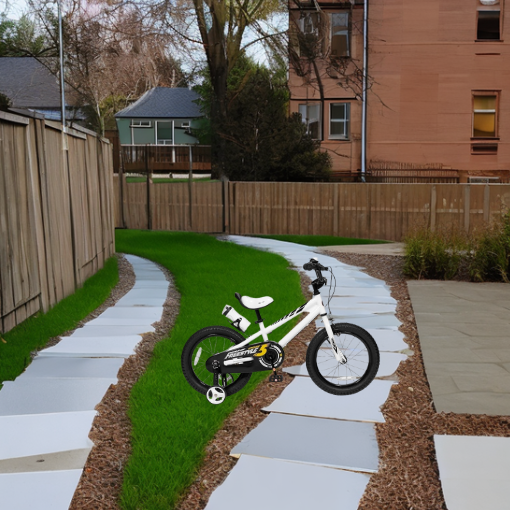